   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
          longitude      latitude  housing_median_age   total_rooms  \
coun

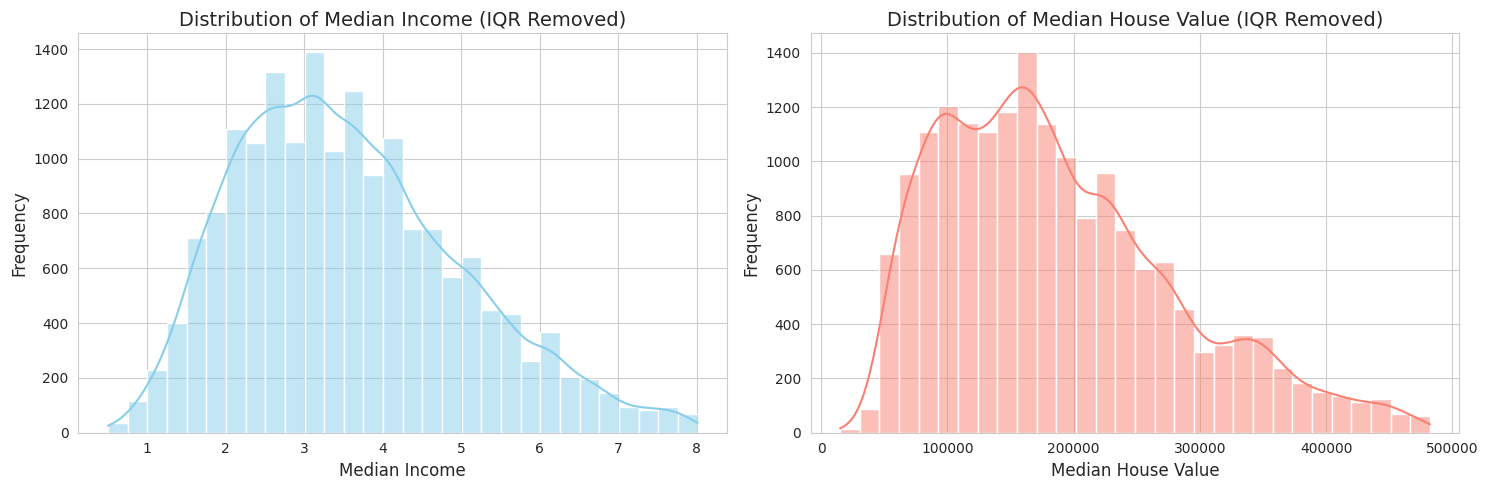

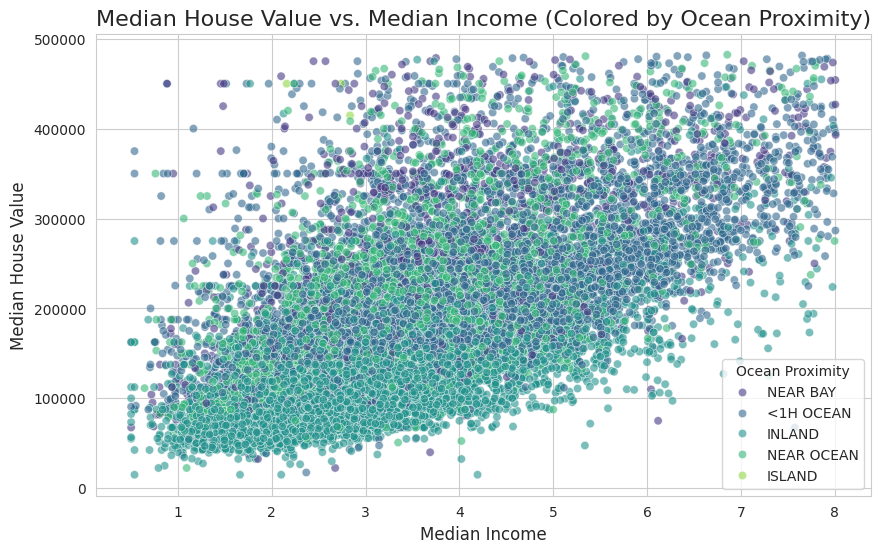

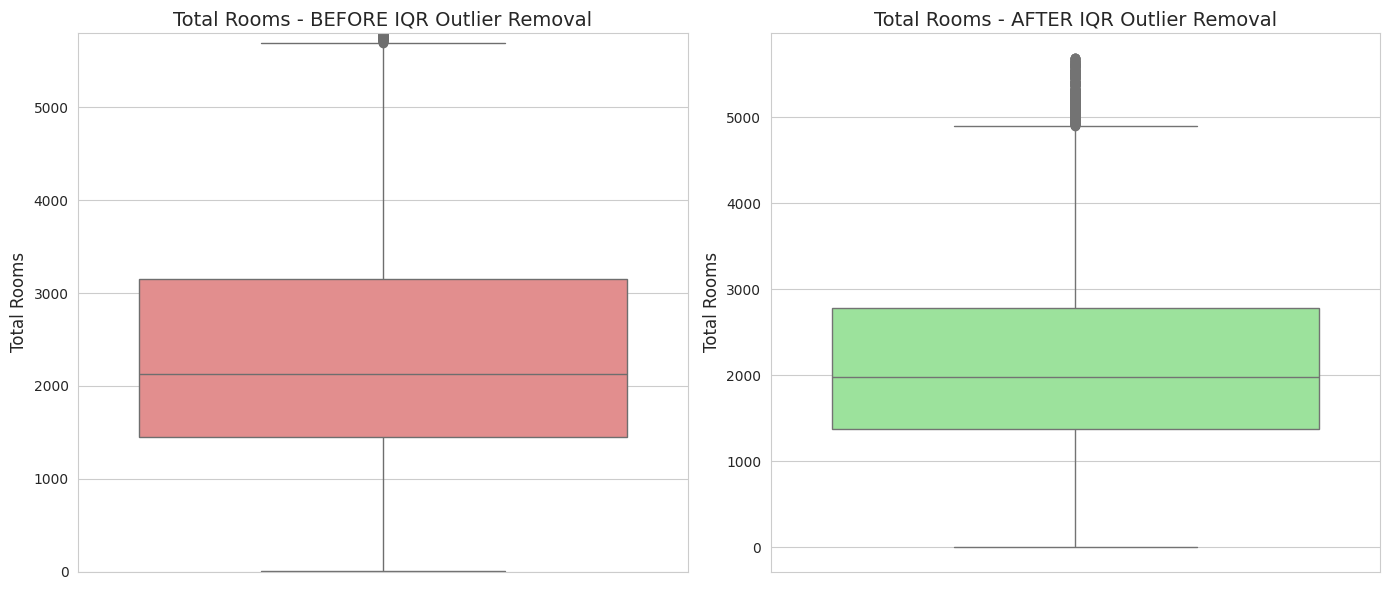

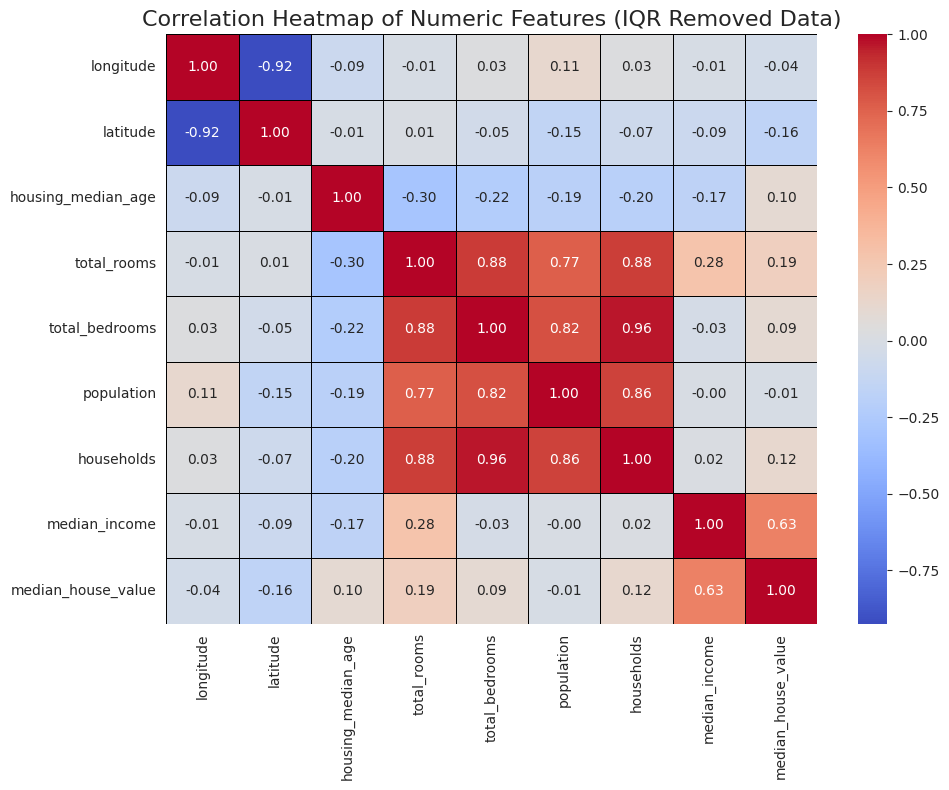

/tmp/ipython-input-1406030508.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='income_level', y='housing_median_age', data=df_iqr_removed, palette='viridis')
/tmp/ipython-input-1406030508.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='income_level', y='housing_median_age', data=df_iqr_removed, palette='magma')


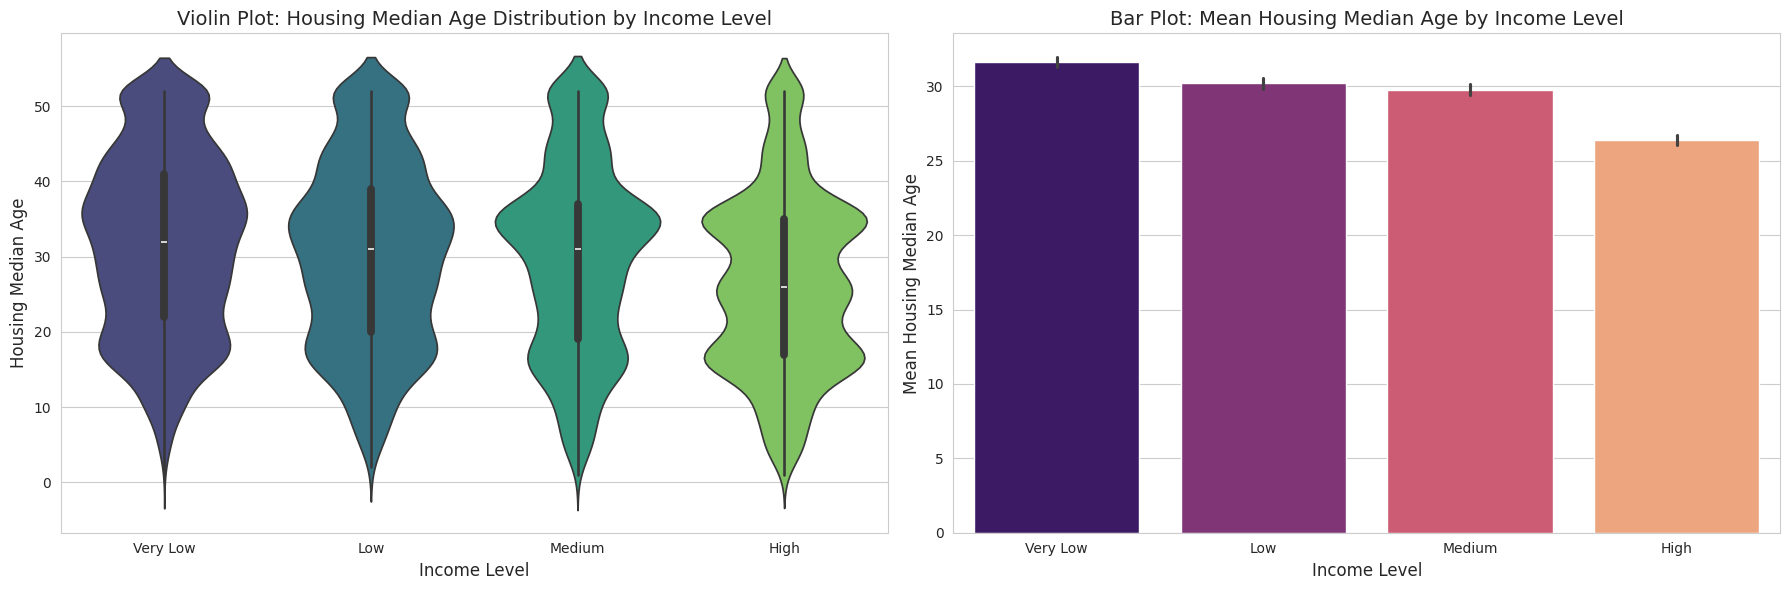

Plots generated and ready for display.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# --- 1. Data Preprocessing (Imputation and IQR Outlier Removal) ---

# Load the dataset
df = pd.read_csv("/content/housing.csv")
print(df.head())
print(df.describe())
print(df.info())
print(df.shape)

# Identify columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include='object').columns

# Copy for imputation
df_imputed = df.copy()

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
df_imputed[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns with most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# IQR Outlier Removal (Removes rows with an outlier in *any* numeric column)
numeric_cols = df_imputed.select_dtypes(include=['int64', 'float64']).columns
outlier_mask = pd.Series(False, index=df_imputed.index)

for col in numeric_cols:
    Q1 = df_imputed[col].quantile(0.25)
    Q3 = df_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = outlier_mask | (df_imputed[col] < lower_bound) | (df_imputed[col] > upper_bound)

# Cleaned DataFrame after IQR removal
df_iqr_removed = df_imputed[~outlier_mask].copy()

# --- NEW STEP: Create new categorical column 'income_level' ---
# Bin 'median_income' into 4 quartiles: 'Very Low', 'Low', 'Medium', 'High'
df_iqr_removed['income_level'] = pd.qcut(
    df_iqr_removed['median_income'],
    q=4,
    labels=['Very Low', 'Low', 'Medium', 'High']
)
# --- END NEW STEP ---

# Select Numeric DataFrames for plotting correlation
numeric_df_cleaned = df_iqr_removed.select_dtypes(include=['float64', 'int64'])

# --- 2. Plot 1: Histograms (Distributions) ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_iqr_removed['median_income'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Median Income (IQR Removed)', fontsize=14)
plt.xlabel('Median Income', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(1, 2, 2)
sns.histplot(df_iqr_removed['median_house_value'], kde=True, bins=30, color='salmon')
plt.title('Distribution of Median House Value (IQR Removed)', fontsize=14)
plt.xlabel('Median House Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show() # Show plot 1

# --- 3. Plot 2: Scatter Plot (Relationship) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_income', y='median_house_value', hue='ocean_proximity', data=df_iqr_removed, palette='viridis', alpha=0.6)
plt.title('Median House Value vs. Median Income (Colored by Ocean Proximity)', fontsize=16)
plt.xlabel('Median Income', fontsize=12)
plt.ylabel('Median House Value', fontsize=12)
plt.legend(title='Ocean Proximity')
plt.show() # Show plot 2

# --- 4. Plot 3: Box Plots for Outlier Comparison (Before & After) ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_imputed['total_rooms'], color='lightcoral')
plt.title('Total Rooms - BEFORE IQR Outlier Removal', fontsize=14)
plt.ylabel('Total Rooms', fontsize=12)
Q3 = df_imputed['total_rooms'].quantile(0.75)
IQR = Q3 - df_imputed['total_rooms'].quantile(0.25)
plt.ylim(0, Q3 + 1.5 * IQR + 100)
plt.subplot(1, 2, 2)
sns.boxplot(y=df_iqr_removed['total_rooms'], color='lightgreen')
plt.title('Total Rooms - AFTER IQR Outlier Removal', fontsize=14)
plt.ylabel('Total Rooms', fontsize=12)
plt.tight_layout()
plt.show() # Show plot 3

# --- 5. Plot 4: Heatmap (Correlation) ---
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=.5, linecolor='black')
plt.title('Correlation Heatmap of Numeric Features (IQR Removed Data)', fontsize=16)
plt.tight_layout()
plt.show() # Show plot 4

# --- 6. Plot 5: Violin and Bar Plot (Categorical Distribution Comparison with New Columns) ---
plt.figure(figsize=(18, 6))

# Violin Plot (New Columns)
plt.subplot(1, 2, 1)
sns.violinplot(x='income_level', y='housing_median_age', data=df_iqr_removed, palette='viridis')
plt.title('Violin Plot: Housing Median Age Distribution by Income Level', fontsize=14)
plt.xlabel('Income Level', fontsize=12)
plt.ylabel('Housing Median Age', fontsize=12)

# Bar Plot (Replaced Stripplot, New Columns)
plt.subplot(1, 2, 2)
sns.barplot(x='income_level', y='housing_median_age', data=df_iqr_removed, palette='magma')
plt.title('Bar Plot: Mean Housing Median Age by Income Level', fontsize=14)
plt.xlabel('Income Level', fontsize=12)
plt.ylabel('Mean Housing Median Age', fontsize=12)

plt.tight_layout()
plt.show() # Show plot 5

# The figures need to be saved for display in this environment.
plt.figure(1).savefig('histograms_distribution.png')
plt.figure(2).savefig('scatter_median_income_vs_value.png')
plt.figure(3).savefig('boxplot_outlier_comparison.png')
plt.figure(4).savefig('heatmap_correlation.png')
plt.figure(5).savefig('violin_barplot_comparison.png')
plt.close('all')
print("Plots generated and ready for display.")